
# 03 — Train & Evaluate (CoF)

Supports three algorithms via a parameter:
- `algo = "xgboost"`
- `algo = "lstm"`
- `algo = "cnn"`

- Loads processed features & labels
- For sequence models, windowize the time-series
- Trains the model and computes metrics: **F1, Recall, ROC-AUC**
- Logs results to `experiments/CoF/runs.csv`


In [1]:

from pathlib import Path
import json, math
import numpy as np
import pandas as pd
from datetime import datetime

# Paths
NB_PATH = Path.cwd()
ROOT = NB_PATH.parents[1] if NB_PATH.name.lower() == 'cof' else NB_PATH
DATA_DIR = ROOT / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
EXPERIMENTS_DIR = ROOT / 'experiments' / 'CoF'

# Load datasets
Xtr = pd.read_parquet(PROCESSED_DIR / 'CoF_X_train.parquet')
Xva = pd.read_parquet(PROCESSED_DIR / 'CoF_X_val.parquet')
Xte = pd.read_parquet(PROCESSED_DIR / 'CoF_X_test.parquet')

ytr = pd.read_parquet(PROCESSED_DIR / 'CoF_y_train.parquet')['CoF'].values
yva = pd.read_parquet(PROCESSED_DIR / 'CoF_y_val.parquet')['CoF'].values
yte = pd.read_parquet(PROCESSED_DIR / 'CoF_y_test.parquet')['CoF'].values


print("Loaded shapes:", Xtr.shape, Xva.shape, Xte.shape, "|", ytr.shape, yva.shape, yte.shape)


Loaded shapes: (629850, 285) (0, 285) (629850, 285) | (629850,) (0,) (629850,)


In [2]:

# --- Choose algorithm here
algo = "cnn"   # one of: "xgboost", "lstm", "cnn"
random_seed = 42
window = 20        # for sequence models
stride = 1
id_col, time_col = 'machine_id','timestamp'


In [3]:

# --- Metrics
from sklearn.metrics import f1_score, recall_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve

def compute_metrics_cls(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    f1  = f1_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_prob)
    except Exception:
        auc = float('nan')
    cm = confusion_matrix(y_true, y_pred)
    return {'f1': f1, 'recall': rec, 'roc_auc': auc, 'cm': cm.tolist()}


In [4]:

# --- Helper: sequence windowing per machine (avoid leakage)
def build_windows(X, y, window=20, stride=1, id_col='machine_id'):
    feats = [c for c in X.columns if c not in [id_col, 'timestamp','__line']]
    Xs, ys = [], []
    for gid, gX in X.groupby(id_col):
        idx = gX.index.values
        for start in range(0, len(gX) - window + 1, stride):
            end = start + window
            sl = gX.iloc[start:end]
            Xs.append(sl[feats].values)        # (window, features)
            ys.append(y[idx[end-1]])           # label at window end
    Xs = np.stack(Xs, axis=0) if Xs else np.empty((0, window, len(feats)))
    ys = np.array(ys)
    return Xs, ys, feats


In [5]:
# --- Helpers: build clean numeric matrices
import numpy as np
import pandas as pd

NUM_EXCLUDE = {id_col, 'timestamp', '__line'}  # things we won't feed to the model

def pick_numeric_feats(df):
    # only numeric dtypes; exclude ids/meta
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    return [c for c in num_cols if c not in NUM_EXCLUDE]

def to_numeric_matrix(df, feats, for_nn=False):
    X = df[feats].copy()
    # coerce anything weird to numeric, keep NaN for XGBoost, fill for NN
    X = X.apply(pd.to_numeric, errors='coerce')
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    if for_nn:
        X = X.fillna(0.0).astype('float32')   # NNs cannot handle NaN
    else:
        X = X.astype('float32')               # XGBoost is ok with NaN
    return X


In [6]:

# --- Train/Eval by algo
results = {}

if algo == "xgboost":
    import xgboost as xgb

    # ✅ pick only numeric features present in TRAIN, exclude id/timestamp/__line
    feats = pick_numeric_feats(Xtr)

    Xtr_mat = to_numeric_matrix(Xtr, feats, for_nn=False)
    Xva_mat = to_numeric_matrix(Xva, feats, for_nn=False)
    Xte_mat = to_numeric_matrix(Xte, feats, for_nn=False)

    ytr_vec = ytr[target].values.ravel() if isinstance(ytr, pd.DataFrame) else np.asarray(ytr).ravel()
    yva_vec = yva[target].values.ravel() if isinstance(yva, pd.DataFrame) else np.asarray(yva).ravel()

    # handle imbalance
    pos = float(ytr_vec.sum())
    neg = float(len(ytr_vec) - pos)
    scale_pos_weight = max(1.0, neg / max(1.0, pos))

    model = xgb.XGBClassifier(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9, random_state=random_seed,
        scale_pos_weight=scale_pos_weight, n_jobs=-1, eval_metric='logloss',
        tree_method="hist"
    )
    model.fit(Xtr_mat, ytr_vec, eval_set=[(Xva_mat, yva_vec)], verbose=False)

    prob = model.predict_proba(Xte_mat)[:, 1]
    results['prob'] = prob
    results['feats'] = feats

elif algo == "lstm":
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np

    feats = pick_numeric_feats(Xtr)
    Xtr_mat = to_numeric_matrix(Xtr, feats, for_nn=True)
    Xva_mat = to_numeric_matrix(Xva, feats, for_nn=True)
    Xte_mat = to_numeric_matrix(Xte, feats, for_nn=True)

    ytr_vec = ytr.values.ravel() if hasattr(ytr, "values") else np.asarray(ytr).ravel()
    yva_vec = yva.values.ravel() if hasattr(yva, "values") else np.asarray(yva).ravel()
    yte_vec = yte.values.ravel() if hasattr(yte, "values") else np.asarray(yte).ravel()

    # ⚠️ make windows with larger stride
    big_stride = max(stride, 10)  # e.g. 10
    Xtr_w, ytr_w, feats = build_windows(
        pd.concat([Xtr[[id_col]], Xtr_mat], axis=1),
        ytr_vec, window=window, stride=big_stride, id_col=id_col
    )
    Xva_w, yva_w, _ = build_windows(
        pd.concat([Xva[[id_col]], Xva_mat], axis=1),
        yva_vec, window=window, stride=big_stride, id_col=id_col
    )
    Xte_w, yte_w, _ = build_windows(
        pd.concat([Xte[[id_col]], Xte_mat], axis=1),
        yte_vec, window=window, stride=big_stride, id_col=id_col
    )

    # 💡 Limit the number of training windows to something manageable
    max_train_windows = 80_000  # tune this depending on RAM
    if len(Xtr_w) > max_train_windows:
        idx = np.random.choice(len(Xtr_w), max_train_windows, replace=False)
        Xtr_w = Xtr_w[idx]
        ytr_w = ytr_w[idx]

    print("LSTM train windows:", Xtr_w.shape)

    model = keras.Sequential([
        keras.layers.Input(shape=(window, len(feats))),
        keras.layers.LSTM(64, return_sequences=False),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.Recall(name="recall")]
    )
    model.fit(
        Xtr_w, ytr_w,
        validation_data=(Xva_w, yva_w),
        epochs=10, batch_size=256,
        verbose=1
    )

    prob = model.predict(Xte_w).ravel()
    results["prob"] = prob
    results["feats"] = feats
    results["model"] = model
    results["yte_w"] = yte_w

elif algo == "cnn":
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np

    print("\n=== Building CNN windows ===")

    # numeric feature selection
    feats = pick_numeric_feats(Xtr)

    # NN needs NaNs filled -> to_numeric_matrix(..., for_nn=True)
    Xtr_mat = to_numeric_matrix(Xtr, feats, for_nn=True)
    Xva_mat = to_numeric_matrix(Xva, feats, for_nn=True)
    Xte_mat = to_numeric_matrix(Xte, feats, for_nn=True)

    # flatten y
    ytr_vec = ytr.values.ravel() if hasattr(ytr, "values") else np.asarray(ytr).ravel()
    yva_vec = yva.values.ravel() if hasattr(yva, "values") else np.asarray(yva).ravel()
    yte_vec = yte.values.ravel() if hasattr(yte, "values") else np.asarray(yte).ravel()

    # ---- BUILD WINDOWS (W3 recommended stride)
    big_stride = max(stride, 10)   # larger stride = fewer windows

    Xtr_w, ytr_w, feats = build_windows(
        pd.concat([Xtr[[id_col]], Xtr_mat], axis=1),
        ytr_vec,
        window=window,
        stride=big_stride,
        id_col=id_col
    )

    Xva_w, yva_w, _ = build_windows(
        pd.concat([Xva[[id_col]], Xva_mat], axis=1),
        yva_vec,
        window=window,
        stride=big_stride,
        id_col=id_col
    )

    Xte_w, yte_w, _ = build_windows(
        pd.concat([Xte[[id_col]], Xte_mat], axis=1),
        yte_vec,
        window=window,
        stride=big_stride,
        id_col=id_col
    )

    # ---- OPTIONAL SAFETY: cap training windows to avoid MemoryError
    max_train_windows = 80_000   # adjust based on RAM
    if len(Xtr_w) > max_train_windows:
        idx = np.random.choice(len(Xtr_w), max_train_windows, replace=False)
        Xtr_w = Xtr_w[idx]
        ytr_w = ytr_w[idx]

    print("CNN train windows:", Xtr_w.shape)
    print("CNN val windows:", Xva_w.shape)
    print("CNN test windows:", Xte_w.shape)

    # ---- DEFINE CNN MODEL
    model = keras.Sequential([
        keras.layers.Input(shape=(window, len(feats))),
        keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='binary_crossentropy',
        metrics=[keras.metrics.Recall(name="recall")]
    )

    # ---- TRAIN CNN
    model.fit(
        Xtr_w, ytr_w,
        validation_data=(Xva_w, yva_w),
        epochs=10,
        batch_size=256,
        verbose=1
    )

    # ---- PREDICT with CNN (no predict_proba)
    prob = model.predict(Xte_w, batch_size=256).ravel()

    results['prob'] = prob
    results['feats'] = feats
    results['model'] = model
    results['yte_w'] = yte_w


else:
    raise ValueError("Unknown algo. Use one of: xgboost, lstm, cnn")




=== Building CNN windows ===
CNN train windows: (62982, 20, 282)
CNN val windows: (0, 20, 282)
CNN test windows: (62982, 20, 282)
Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.4646 - recall: 0.0000e+00 
Epoch 2/10
 16/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5795 - recall: 0.0000e+00

d:\Documents\Thesis\pdm-project\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5335 - recall: 0.0000e+00
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4491 - recall: 0.0000e+00
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3799 - recall: 0.0000e+00
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3231 - recall: 0.0000e+00
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2764 - recall: 0.0000e+00
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2378 - recall: 0.0000e+00
Epoch 8/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2056 - recall: 0.0000e+00
Epoch 9/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1788 - recall: 0.0000e+00
Epoch 10/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1562 - recall: 0.0000e+00
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [7]:

import numpy as np

# --- Evaluate & log
y_prob = results['prob']
thr = results.get('best_thr', 0.1)

if algo == 'xgboost':
    # yte might be a DataFrame OR already a 1D array
    if hasattr(yte, "values"):  # DataFrame / Series
        y_true = yte.values.ravel()
    else:  # already ndarray / list
        y_true = np.asarray(yte).ravel()
else:
    # for LSTM/CNN windowed labels
    y_true = np.asarray(yte_w).ravel()

m = compute_metrics_cls(y_true, y_prob, threshold=thr)
print("Using threshold:", thr)
m

m


Using threshold: 0.1


{'f1': 0.03251956328194555,
 'recall': 1.0,
 'roc_auc': 0.5,
 'cm': [[0, 61941], [0, 1041]]}

In [8]:

# --- Log to experiments/CoF/runs.csv
import pandas as pd, json
from datetime import datetime
runs_csv = EXPERIMENTS_DIR / 'runs.csv'
if not runs_csv.exists():
    pd.DataFrame(columns=[
        'timestamp','task','algo','line','seed','params_json',
        'f1','recall','roc_auc','dataset_hash','notes','artifact_dir'
    ]).to_csv(runs_csv, index=False)

row = {
    'timestamp': datetime.utcnow().isoformat(),
    'task': 'CoF',
    'algo': algo,
    'line': -1,
    'seed': 42,
    'params_json': json.dumps({'algo': algo, 'window': int(window)}),
    'f1': m.get('f1'),
    'recall': m.get('recall'),
    'roc_auc': m.get('roc_auc'),
    'dataset_hash': '',
    'notes': '',
    'artifact_dir': ''
}
df_runs = pd.read_csv(runs_csv)
df_runs = pd.concat([df_runs, pd.DataFrame([row])], ignore_index=True)
df_runs.to_csv(runs_csv, index=False)
print("Logged:", runs_csv)


Logged: d:\Documents\Thesis\pdm-project\experiments\CoF\runs.csv


C:\Users\Richard Dammara\AppData\Local\Temp\ipykernel_16608\2884199193.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_runs = pd.concat([df_runs, pd.DataFrame([row])], ignore_index=True)


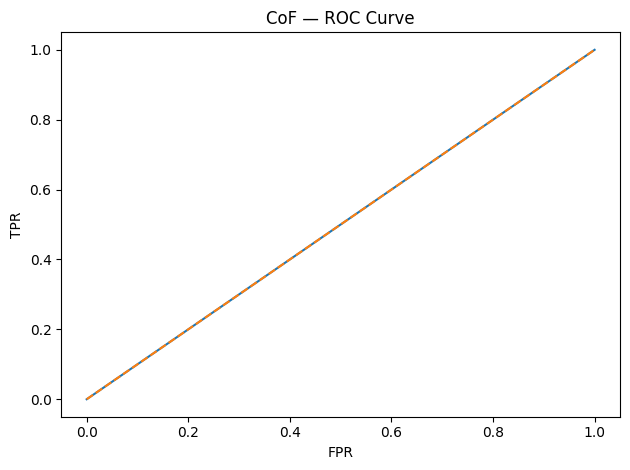

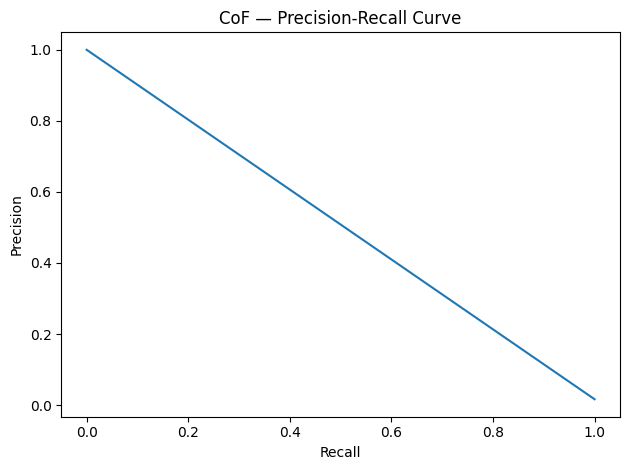

<Figure size 640x480 with 0 Axes>

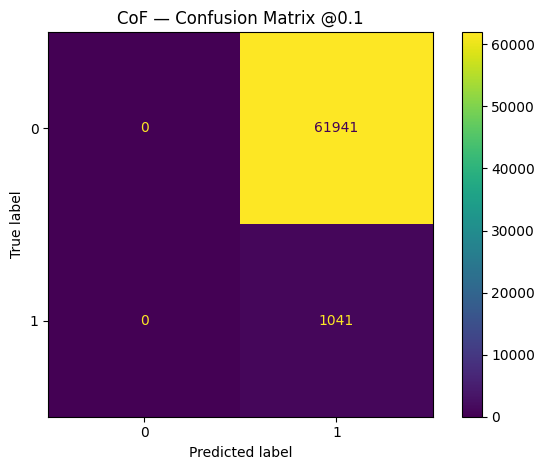

In [9]:

# --- Curves & Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

y_true = yte if algo=='xgboost' else yte_w

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title('CoF — ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.tight_layout()
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure()
plt.plot(rec, prec)
plt.title('CoF — Precision-Recall Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.tight_layout()
plt.show()

# Confusion matrix at 0.5
cm = confusion_matrix(y_true, (y_prob>=0.1).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure()
disp.plot(values_format='d')
plt.title('CoF — Confusion Matrix @0.1')
plt.tight_layout()
plt.show()
